<a href="https://colab.research.google.com/github/luoqianlin/deep-learning-demo/blob/main/%E5%9B%BA%E5%AE%9A%E9%95%BF%E5%BA%A6%E9%AA%8C%E8%AF%81%E7%A0%81%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captcha

     |████████████████████████████████| 102kB 6.3MB/s 


In [3]:
from captcha.image import ImageCaptcha

import random
import numpy as np

import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil
import os

In [4]:

NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
             'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
             'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER  # 验证码字符集
CAPTCHA_LEN = 4  # 验证码长度
CAPTCHA_HEIGHT = 60  # 验证码高度
CAPTCHA_WIDTH = 160  # 验证码宽度

TRAIN_DATASET_SIZE = 25000  # 验证码数据集大小
TEST_DATASET_SIZE = 10000
TRAIN_DATA_DIR = './train-data/'  # 验证码数据集目录
TEST_DATA_DIR = './test-data/'

In [5]:

def gen_random_text(charset=CAPTCHA_CHARSET, length=CAPTCHA_LEN):
    text = [random.choice(charset) for _ in range(length)]
    return ''.join(text)


def create_captcha_dataset(size=100,data_dir='./data/',
                           height=60,
                           width=160,
                           image_format='.png'):
    # 如果保存验证码图像，先清空 data_dir 目录

    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    os.makedirs(data_dir)

    # 创建 ImageCaptcha 实例 captcha
    captcha = ImageCaptcha(width=width, height=height)

    for i in range(size):
        # 生成随机的验证码字符
        text = gen_random_text(CAPTCHA_CHARSET, CAPTCHA_LEN)
        captcha.write(text, data_dir + str(i) + "_" + text + image_format)

    return None

## 生成验证码数据集

In [6]:
create_captcha_dataset(TRAIN_DATASET_SIZE, TRAIN_DATA_DIR)
create_captcha_dataset(TEST_DATASET_SIZE, TEST_DATA_DIR)

In [7]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import glob
import pickle

import numpy as np

import matplotlib.pyplot as plt
import os

## 定义模型超参数

In [8]:

BATCH_SIZE = 200
EPOCHS = 130
OPT = 'adam'
LOSS = 'sparse_categorical_crossentropy'

MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

filename_str = "{}captcha_{}_{}_bs_{}_epochs_{}{}"

# 模型网络结构文件
MODEL_VIS_FILE = 'captcha_classfication' + '.png'
# 模型文件
MODEL_FILE = filename_str.format(MODEL_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), MODEL_FORMAT)
# 训练记录文件
HISTORY_FILE = filename_str.format(HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), HISTORY_FORMAT)


In [9]:

def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B
    # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(img[..., :3], [0.299, 0.587, 0.114])


def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError('Error: length of captcha should be {}, but got {}'.format(length, text_len))

    # 生成一个形如（CAPTCHA_LEN*CAPTHA_CHARSET,) 的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length * len(charset))
    for i in range(length):
        # One-hot 编码验证码中的每个数字
        # 每个字符的热码 = 索引 + 偏移量
        vec[charset.index(text[i]) + i * len(charset)] = 1
    return vec


def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text


def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)

    return batch, input_shape


def load_data(dir, limit=-1):
    x = []
    y = []
    k = 0
    for filename in glob.glob(dir + '*.png'):
        x.append(np.array(Image.open(filename)))
        y.append(os.path.basename(filename).rstrip('.png')[-4:])
        k += 1
        if limit > 0 and k >= limit:
            break

    return x, y

In [10]:

list_ds = tf.data.Dataset.list_files(TRAIN_DATA_DIR + '*.png')
list_ds2 = tf.data.Dataset.list_files(TEST_DATA_DIR + '*.png')


def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-1]
    label = tf.strings.substr(label, tf.strings.length(label) - 8, 4)
    label = tf.strings.to_number(tf.strings.bytes_split(label), tf.int32)
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, 1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


input_ds = list_ds.map(parse_image).batch(BATCH_SIZE)
valid_ds = list_ds2.map(parse_image).batch(BATCH_SIZE)

## 定义模型

In [11]:

# 输入层
inputs = Input(shape=(60, 160, 1), name="inputs")
# 第1层卷积
conv1 = Conv2D(16, (3, 3), name="conv1", padding='same',use_bias=False)(inputs)
bn1 = BatchNormalization(name="bn1")(conv1)
relu1 = Activation('relu', name="relu1")(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2), name="pool1")(relu1)

# 第2层卷积
conv2 = Conv2D(64, (3, 3), name="conv2", padding='same',use_bias=False)(pool1)
bn2 = BatchNormalization(name="bn2")(conv2)
relu2 = Activation('relu', name="relu2")(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2), name="pool2")(relu2)

# 第3层卷积
conv3 = Conv2D(128, (3, 3), name="conv3", padding='same',use_bias=False)(pool2)
bn3 = BatchNormalization(name="bn3")(conv3)
relu3 = Activation('relu', name="relu3")(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2), name="pool3")(relu3)

# 第4层卷积
conv4=Conv2D(256, (3, 3), name="conv4", padding='same',use_bias=False)(pool3)
bn4 = BatchNormalization(name="bn4")(conv4)
relu4 = Activation('relu', name="relu4")(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2), name="pool4")(relu4)

# 将 Pooled feature map 摊平后输入全连接网络
x = Flatten()(pool4)

# 4个全连接层分别做10分类，分别对应4个字符。
x = [Dense(10, activation='softmax', name='fc1%d' % (i + 1))(x) for i in range(4)]
x= Concatenate()(x)
outs = Reshape((4, 10))(x)
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# 定义模型的输入与输出
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer=OPT, loss=LOSS, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 160, 16)  144         inputs[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 60, 160, 16)  64          conv1[0][0]                      
__________________________________________________________________________________________________
relu1 (Activation)              (None, 60, 160, 16)  0           bn1[0][0]                        
______________________________________________________________________________________________

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", patience=4, verbose=1)

history = model.fit(input_ds,epochs=EPOCHS,
                    verbose=2,
                    validation_data=valid_ds,
                    callbacks=earlystop)

if not tf.io.gfile.exists(MODEL_DIR):
    tf.io.gfile.makedirs(MODEL_DIR)

model.save(MODEL_FILE)
print('Saved trained model at %s ' % MODEL_FILE)

if tf.io.gfile.exists(HISTORY_DIR) == False:
    tf.io.gfile.makedirs(HISTORY_DIR)

with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history.history, f)

print(HISTORY_FILE)

Epoch 1/130
125/125 - 28s - loss: 2.9772 - accuracy: 0.1844 - val_loss: 2.3778 - val_accuracy: 0.1024
Epoch 2/130
125/125 - 20s - loss: 0.6959 - accuracy: 0.7994 - val_loss: 2.2030 - val_accuracy: 0.2660
Epoch 3/130
125/125 - 20s - loss: 0.3173 - accuracy: 0.9051 - val_loss: 1.2039 - val_accuracy: 0.6109
Epoch 4/130
125/125 - 20s - loss: 0.1961 - accuracy: 0.9391 - val_loss: 0.5707 - val_accuracy: 0.8158
Epoch 5/130
125/125 - 20s - loss: 0.1277 - accuracy: 0.9606 - val_loss: 0.2830 - val_accuracy: 0.9129
Epoch 6/130
125/125 - 19s - loss: 0.0828 - accuracy: 0.9756 - val_loss: 0.8195 - val_accuracy: 0.7364
Epoch 7/130
125/125 - 19s - loss: 0.0553 - accuracy: 0.9843 - val_loss: 0.1829 - val_accuracy: 0.9424
Epoch 8/130
125/125 - 20s - loss: 0.0372 - accuracy: 0.9900 - val_loss: 0.3558 - val_accuracy: 0.8935
Epoch 9/130
125/125 - 20s - loss: 0.0222 - accuracy: 0.9954 - val_loss: 0.3277 - val_accuracy: 0.9089
Epoch 10/130
125/125 - 20s - loss: 0.0119 - accuracy: 0.9982 - val_loss: 0.1263 - 

In [131]:
test_dataset_num=54
test_ds=tf.data.Dataset.list_files(TEST_DATA_DIR + '*.png').take(test_dataset_num)
test_data=list(test_ds.map(parse_image).batch(test_dataset_num))[0]
test_dataX=test_data[0].numpy()
test_dataY=test_data[1].numpy()

In [132]:
predicts=model.predict(test_data[0])

In [133]:
predictsY=np.argmax(predicts,axis=-1)

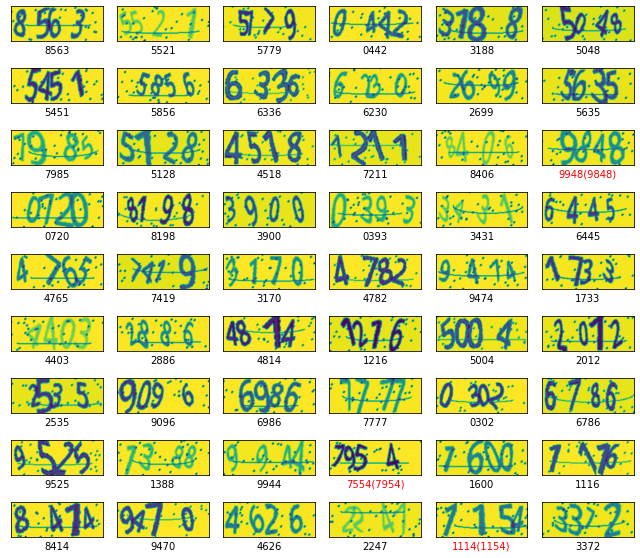

In [139]:
%matplotlib inline
plt.figure(figsize=(9,8))
for i in range(len(test_dataX)):
  img=test_dataX[i].squeeze()
  plt.subplot(9,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  label=''.join(map(str,predictsY[i].tolist()))
  real_label=''.join(map(str,test_dataY[i].tolist()))
  if (predictsY[i]==test_dataY[i]).all():
     color = 'blue'
     plt.xlabel(label)
  else:
     color = 'red'
     plt.xlabel('{}({})'.format(label,real_label), color=color)
  
  plt.imshow(img)
plt.tight_layout()
plt.show()

In [140]:
len(os.listdir(TRAIN_DATA_DIR)),len(os.listdir(TEST_DATA_DIR))

(25000, 10000)

## 训练结果可视化

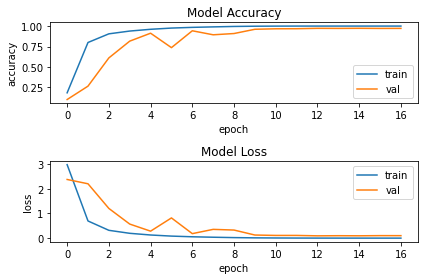

In [142]:
history_file = HISTORY_FILE
with open(history_file, 'rb') as f:
    history = pickle.load(f)

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

plt.show()